In [4]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib.pyplot as mpl 
import matplotlib.pyplot as plt

%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

In [193]:
import pims
import pySPM as spm 
import trackpy as tp
import glob

#@pims.pipeline
#def gray(image):
#    return image[:, :, 1]  # Take just the green channel
#frames = gray(pims.open('../track_molecules/*.bmp'))

class SXMReader(pims.FramesSequence):
    def __init__(self, filename_pattern):
        self.filenames = glob.glob(filename_pattern)
        self.scans = [spm.SXM(filename) for filename in self.filenames]
        self.z_data = np.array([s.get_channel("Z").correct_plane().pixels for s in self.scans])
        min_z = np.min(self.z_data)
        max_z = np.max(self.z_data)
        self.z_data -= min_z
        self.z_data /= max_z-min_z
        self._len = len(self.z_data)
        self._dtype = self.z_data.dtype
        self._frame_shape = self.z_data[0].shape
        self.scan_size = self.scans[0].size
        self.meters_per_pixel = self.scan_size['real']['x']/self.scan_size['pixels']['x']
       
    def get_frame(self, i):
        # Access the data you need and get it into a numpy array.
        # Then return a Frame like so:
        return pims.Frame(self.z_data[i], frame_no=i)

    def __len__(self):
        return self._len

    @property
    def frame_shape(self):
        return self._frame_shape

    @property
    def pixel_type(self):
        return self._dtype

if False:
    frames = SXMReader("data_high_density/*.sxm")
    molecule_size = 13
    min_mass = 5.0
    min_size = 3.0
    max_ecc = 0.3
else:
    frames = SXMReader("examples/gate_dep/*.sxm")
    molecule_size = 5
    min_mass = 0.1
    min_size = 1.0
    max_ecc = 0.3

#print(frames[0])
    
#plt.imshow(frames[7])

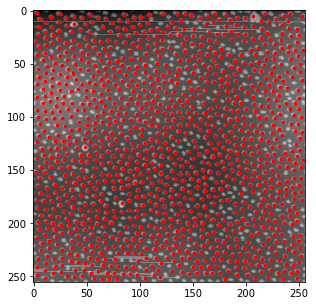

In [203]:
frame_id = 9
f = tp.locate(frames[frame_id], molecule_size, minmass=min_mass)
tp.annotate(f, frames[frame_id], plot_style={'markersize' : 2})


In [204]:
boundary = (0, frames.frame_shape[0], 0, frames.frame_shape[1])
print(boundary)

(0, 256, 0, 256)


In [ ]:
from trackpy.utils import cKDTree, guess_pos_columns
from trackpy.static import MAX_ARRAY_SIZE 
# modified from pair_correlation_2d
def angular_correlation(feat, search_radius=None, search_radius_factor=2, fraction=1., dtheta=np.pi*0.025, dr=None, dr_factor=None, p_indices=None,
                        ndensity=None, boundary=None, handle_edge=True,
                        max_rel_ndensity=10, remove_nearest_neighbor=True):
    """Calculate the angular distribution function in 2 dimensions.
    Parameters
    ----------
    feat : Pandas DataFrame
        DataFrame containing the x and y coordinates of particles
    search_radius : float
        Maximum distance to calculate g(r)
    search_radius_factor : float
        if search_radius is not specified, specifies search_radius in approximate lattice constants, estimated from the density
    fraction : float, optional
        The fraction of particles to calculate g(r) with. May be used to
        increase speed of function. Particles selected at random.
    dtheta : float, optional
        The bin width
    p_indices : list or ndarray, optional
        Only consider a pair of particles if one of them is in 'p_indices'.
        Uses zero-based indexing, regardless of how 'feat' is indexed.
    ndensity : float, optional
        Density of particle packing. If not specified, density will be
        calculated assuming rectangular homogeneous arrangement.
    boundary : tuple, optional
        Tuple specifying rectangular prism boundary of particles (xmin, xmax,
        ymin, ymax). Must be floats. Default is to assume a rectangular packing.
        Boundaries are determined by edge particles.
    handle_edge : boolean, optional
        If true, compensate for reduced area around particles near the edges.
    max_rel_ndensity : number, optional
        The relative maximum density deviation, used to estimate the maximum
        number of neighbours. Lower numbers increase performance, until the
        method fails because there are more neighbours than expected.
    remove_nearest_neighbor : boolean, optional
        If true, the nearest neighbor of each point is excluded to avoid a giant peak at theta = 0.
    Returns
    -------
    r_edges : array
        The bin edges, with 1 more element than g_r.
    g_r : array
        The values of g_r.
    """

    if boundary is None:
        xmin, xmax, ymin, ymax = (feat.x.min(), feat.x.max(),
                                  feat.y.min(), feat.y.max())
    else:
        xmin, xmax, ymin, ymax = boundary
        
    if ndensity is None:  # particle packing density
        ndensity = (feat.x.count() - 1) / ((xmax - xmin) * (ymax - ymin))

    lattice_constant = np.sqrt(1/ndensity)
    if search_radius is None:
        search_radius = search_radius_factor*lattice_constant

    if boundary is not None:
        # Disregard all particles outside the bounding box
        search_feat = feat[(feat.x >= xmin+search_radius) & (feat.x <= xmax-search_radius) &
                           (feat.y >= ymin+search_radius) & (feat.y <= ymax-search_radius)]
    if p_indices is None:
        if fraction == 1.:
            p_indices = slice(len(search_feat))
        else:  # grab random sample of particles
            p_indices = np.random.randint(0, len(search_feat),
                                          int(fraction * len(search_feat)))

    # radii bins to search for particles
    theta_edges = np.arange(-np.pi, np.pi+dtheta, dtheta)

    # initialize kdtree for fast neighbor search
    ckdtree = cKDTree(feat[['x', 'y']])
    pos = np.array(search_feat[['x','y']][p_indices])

    # Estimate upper bound for neighborhood particle count
    max_p_count = int(np.pi * (search_radius)**2 *
                      ndensity * max_rel_ndensity)
    # Protect against too large memory usage
    if len(pos) * max_p_count > MAX_ARRAY_SIZE:
          raise MemoryError('The distance array will be larger than the maximum '
                          'allowed size. Please reduce the search_radius or '
                          'max_rel_ndensity. Or run the analysis on a fraction '
                          'of the features using the fraction parameter.')

    dist, idxs = ckdtree.query(pos, k=max_p_count, distance_upper_bound=search_radius)
    if np.any(np.isfinite(dist[:, -1])):
        raise RuntimeError("There are too many particle pairs per particle. "
                           "Apparently, density fluctuations are larger than "
                           "max_rel_ndensity. Please increase it.")

    # drop zero and infinite dist values
    mask = (dist > 0) & np.isfinite(dist)
    #dist = dist[mask]
    dist = np.array([d[m] for d,m in zip(dist, mask)])
    idxs = np.array([i[m] for i,m in zip(idxs, mask)])
    neighbor_pos = np.array([ckdtree.data[i] for i in idxs])
    thetas = np.array([np.arctan2(ckdtree.data[i].T[1]-pos[n][1], ckdtree.data[i].T[0]-pos[n][0]) for n, i in enumerate(idxs)])
    theta_0s = np.array([theta[0] for theta in thetas])
    if(remove_nearest_neighbor):
        thetas = [theta[1:] for theta in thetas]
        dist = [d[1:] for d in dist]
    thetas -= theta_0s
    thetas = np.concatenate(thetas)
    if dr_factor is not None:
        dr = dr_factor*lattice_constant 
    if dr is not None:
        dist = np.concatenate(dist)
        r_edges = np.arange(0, search_radius+dr, dr)
        distribution, theta_edges, r_edges = np.histogram2d(thetas, dist, [theta_edges, r_edges], weights=1/(2*np.pi*dist))
        return distribution, theta_edges, r_edges
    theta_distribution = np.histogram(thetas, bins=theta_edges)[0]
    return theta_distribution, theta_edges

theta_distribution, theta_edges = angular_correlation(f, search_radius_factor = 1.5, dtheta=np.pi/50, boundary=boundary, remove_nearest_neighbor=True)
theta_centers = 0.5*(theta_edges[1:]+theta_edges[:-1])
bar_width = theta_edges[1]-theta_edges[0]
ax = plt.subplot(111, polar=True)
ax.set_xticks(np.linspace(0, 2*np.pi, 6, endpoint=False))
ax.bar(theta_edges[:-1], theta_distribution, bar_width, yerr=np.sqrt(theta_distribution))

full_distribution, theta_edges, r_edges = angular_correlation(f, search_radius_factor = 4.0, dtheta=np.pi/50, dr_factor=0.1, boundary=boundary, remove_nearest_neighbor=True)
#theta_centers = 0.5*(theta_edges[1:]+theta_edges[:-1])
#r_centers = 0.5*(r_edges[1:]+r_edges[:-1])
#bar_width = theta_edges[1]-theta_edges[0]
theta, r = np.meshgrid(theta_edges, r_edges)
plt.figure()
ax = plt.subplot(111, polar=True)
ax.set_xticks(np.linspace(0, 2*np.pi, 6, endpoint=False))
ax.set_yticks(np.arange(0, max(r_edges), 7))
ax.pcolormesh(theta, r, full_distribution.T, cmap='viridis')
#ax.grid(c='w')